In [1]:
import os
import re
import sys
import time
import json
import nltk
import swifter
import requests
import warnings
import random
import finlab_crypto
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from collections import Counter
from nltk.corpus import stopwords
nltk.download('stopwords')
plt.rcParams["figure.figsize"] = 15, 6
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yangwang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import os
import sys

MODULE_PATH = os.path.abspath(os.path.join('../..'))
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH + "\\src")

In [3]:
from preparation.utils import seed_everything, read_csv_from_folder, progressbar, DictObj
from processing.preprocess import contractions_dict, expand_contractions
from processing.load_data import CryptoLoader, triple_barrier

seed_everything(seed=914)

# Load Data

## Twitter Data

In [4]:
twitter_df = pd.read_csv(r"G:/ML-for-Crypto/data/raw/twitter/TwitterV2.csv")
twitter_df = twitter_df.drop_duplicates(subset=["tweet"])
twitter_df = twitter_df.set_index("date")
twitter_df.head()

,tweet,username,clean_tweet
date,,,
2020-11-28,Do you remember when you joined Twitter? I do!...,bitcoinforumcom,do you remember when you joined twitter i do m...
2020-11-25,Did You Notice? Bitcoin is Almost at $20K and ...,bitcoinforumcom,did you notice bitcoin is almost at 20k and fe...
2020-11-25,I bought my first Bitcoin! https://t.co/TbqUA...,bitcoinforumcom,i bought my first bitcoin bitcoin bitcoinforum
2020-11-25,Greek smaller letter Koppa (Ï) for Satoshi? ...,bitcoinforumcom,greek smaller letter koppa ï for satoshi bitco...
2020-11-25,"If you buy BTC via PayPal, you don't actually ...",bitcoinforumcom,if you buy btc via paypal you don t actually o...


## Crypto Data

In [5]:
loader = CryptoLoader(symbol="BTC-USD", source="yahoo")
crypto_df = loader.load_crypto()
crypto_df.tail(3)

,open,high,low,close,adj close,volume,triple_barrier_signal
date,,,,,,,
2021-03-07,48918.679688,51384.367188,48918.679688,51206.691406,51206.691406,43137459378,1.0
2021-03-08,51174.117188,52314.070312,49506.054688,52246.523438,52246.523438,48597428048,1.0
2021-03-09,52119.925781,54740.375000,51987.851562,54494.929688,54494.929688,52153094144,1.0


# Text Preprocessing

In [6]:
def clean_tweet(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@[\w]*', '', text)
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    text = text.lower()
    text = " ".join(re.split('\W+', text))
    return text

def remove_stopwords(text):
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    text = pattern.sub('', text)
    return text

In [7]:
twitter_df["clean_tweet"] = twitter_df["tweet"].swifter.apply(clean_tweet)
twitter_df["clean_tweet"] = twitter_df["clean_tweet"].swifter.apply(lambda x: expand_contractions(x, contractions_dict))
twitter_df["clean_tweet"] = twitter_df["clean_tweet"].swifter.apply(lambda x: remove_stopwords(x))
twitter_df.head(5)

Pandas Apply:   0%|          | 0/2433523 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2433523 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2433523 [00:00<?, ?it/s]

,tweet,username,clean_tweet
date,,,
2020-11-28,Do you remember when you joined Twitter? I do!...,bitcoinforumcom,remember joined twitter mytwitteranniversary
2020-11-25,Did You Notice? Bitcoin is Almost at $20K and ...,bitcoinforumcom,notice bitcoin almost 20k fees still ridiculou...
2020-11-25,I bought my first Bitcoin! https://t.co/TbqUA...,bitcoinforumcom,bought first bitcoin bitcoin bitcoinforum
2020-11-25,Greek smaller letter Koppa (Ï) for Satoshi? ...,bitcoinforumcom,greek smaller letter koppa satoshi bitcoin bit...
2020-11-25,"If you buy BTC via PayPal, you don't actually ...",bitcoinforumcom,buy btc via paypal actually many times pp sell...


# Aggregate

## Aggregate Twitter Data and Crypto Data

In [8]:
twitter_df.index = pd.to_datetime(twitter_df.index)
crypto_df.index = pd.to_datetime(crypto_df.index)

In [9]:
text_crypto_agg = twitter_df.join(crypto_df)
text_crypto_agg = text_crypto_agg[["clean_tweet", "triple_barrier_signal"]]
text_crypto_agg.columns = ["title", "label"]
text_crypto_agg = text_crypto_agg.dropna(subset=["label"])
text_crypto_agg.head(5)

,title,label
date,,
2014-09-17,21st century space race take place among billi...,-1.0
2014-09-17,china recent stimulus becomes rorschach test s...,-1.0
2014-09-17,billionaire bill koch fights fake wine hint pa...,-1.0
2014-09-17,toronto mayor rob ford diagnosed rare cancer,-1.0
2014-09-17,ipad fans day coming soon,-1.0


In [10]:
text_crypto_agg.shape

(2202308, 2)

## Tokenised

In [11]:
text_crypto_agg["tokenised"] = text_crypto_agg["title"].swifter.apply(lambda x: re.split(r"\W+", x))

Pandas Apply:   0%|          | 0/2202308 [00:00<?, ?it/s]

In [12]:
text_crypto_agg["length"] = text_crypto_agg["tokenised"].swifter.apply(len)

Pandas Apply:   0%|          | 0/2202308 [00:00<?, ?it/s]

In [13]:
text_crypto_agg = text_crypto_agg[text_crypto_agg["length"]>=10]
text_crypto_agg.head()

,title,label,tokenised,length
date,,,,
2014-09-17,billionaire bill koch fights fake wine hint pa...,-1.0,"[billionaire, bill, koch, fights, fake, wine, ...",10
2014-09-17,breaking 319 108 vote u house representatives ...,-1.0,"[breaking, 319, 108, vote, u, house, represent...",13
2014-09-17,u aid syrian rebels stuffed bill also avoids g...,-1.0,"[u, aid, syrian, rebels, stuffed, bill, also, ...",11
2014-09-17,video iphone 6 review man small child like hands,-1.0,"[video, iphone, 6, review, man, small, child, ...",10
2014-09-17,breaking 273 156 vote republican led house rep...,-1.0,"[breaking, 273, 156, vote, republican, led, ho...",14


# EDA

## Word Frequency

In [14]:
freq_d = Counter([token for doc in text_crypto_agg["tokenised"] for token in doc if len(token)!=0])
freq_d = {k: v for k, v in sorted(freq_d.items(), key=lambda item: item[1], reverse=True)}

In [15]:
tokens, counts = zip(*freq_d.items())
indexes = np.arange(len(tokens))

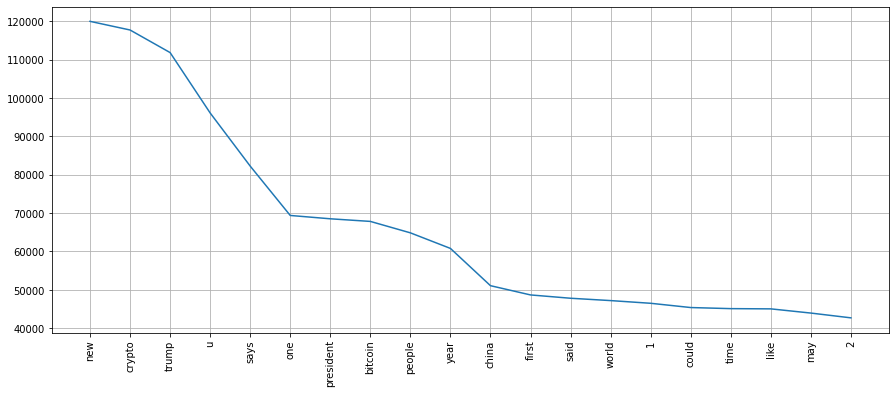

In [16]:
plt.plot(indexes[:20], counts[:20])
plt.xticks(np.arange(20), tokens[:20], rotation=90)
plt.grid()
plt.show()

## PCA

In [17]:
def plot_pca(X, y, num_samples=None, proportion=None, projection="2d"):
    if (num_samples is None) and (proportion is None):
        raise "Please enter 'num_samples' or 'proportion'!"
    
    if num_samples is not None:
        idx = random.sample(range(X.shape[0]), num_samples)
        X = X[idx, :]
        
    if proportion is not None:
        if proportion > 1: raise "Proportion must between 0 and 1!"
        num_samples = X.shape[0] * proportion
        idx = random.sample(range(X.shape[0]), num_samples)
        X = X[idx, :]
        
    if projection == "2d":
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y[idx], alpha=0.7, cmap=cm.Paired)
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.grid()
        plt.show()
        
    elif projection == "3d":
        from mpl_toolkits.mplot3d import Axes3D
        pca = PCA(n_components=3)
        result = pd.DataFrame(pca.fit_transform(X), 
                              columns=['PCA%i' % i for i in range(3)])

        # Plot initialisation
        fig = plt.figure(figsize=(15, 10))
        ax = fig.gca(projection='3d')
        ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], 
                   c=y[idx], cmap=cm.Paired, s=60, alpha=0.7)

        # Make simple, bare axis lines through space:
        xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0, 0))
        ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
        yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0, 0))
        ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
        zAxisLine = ((0, 0), (0, 0), (min(result['PCA2']), max(result['PCA2'])))
        ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

        # label the axes
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        plt.show()

### Count Vectoriser

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=1000)
X = vectorizer.fit_transform(text_crypto_agg["title"])

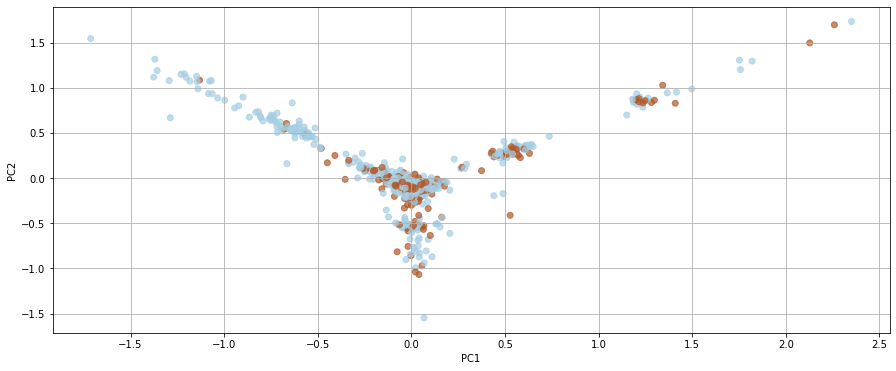

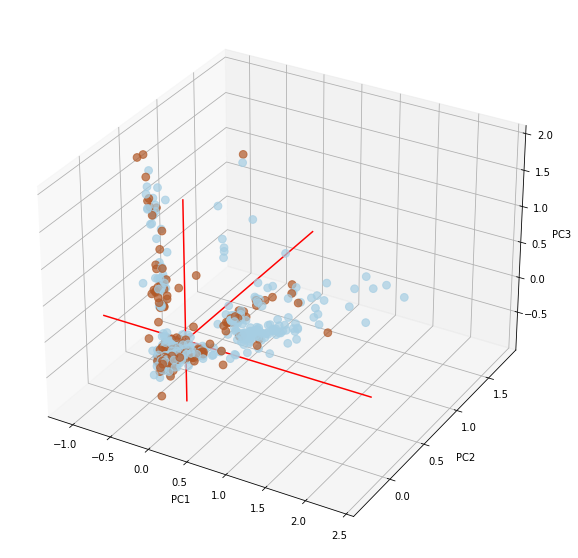

In [19]:
plot_pca(X.toarray(), text_crypto_agg.label, num_samples=1000, projection='2d')
plot_pca(X.toarray(), text_crypto_agg.label, num_samples=1000, projection='3d')

### TFIDF Vectoriser

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=1000)
X = vectorizer.fit_transform(text_crypto_agg["title"])

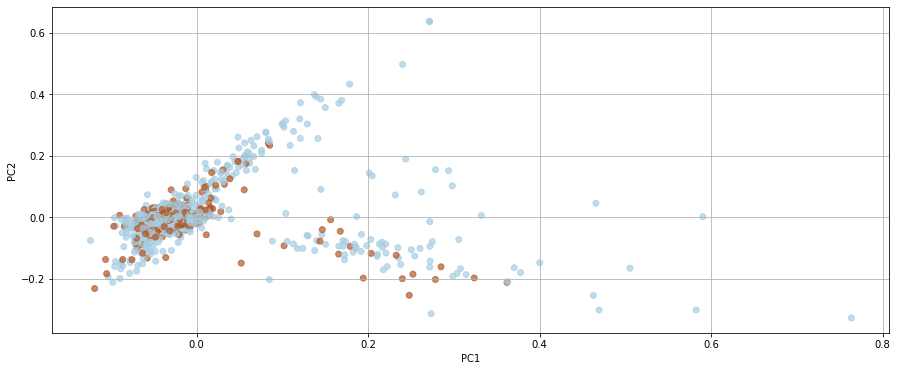

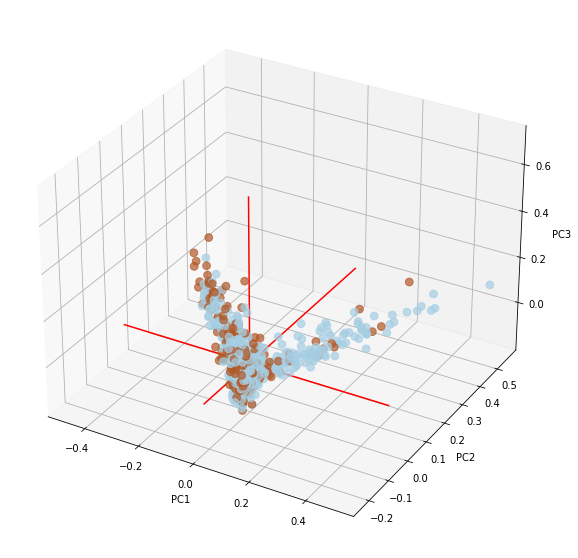

In [21]:
plot_pca(X.toarray(), text_crypto_agg.label, num_samples=1000, projection='2d')
plot_pca(X.toarray(), text_crypto_agg.label, num_samples=1000, projection='3d')

## Visualise TFIDF Score

In [22]:
# Refer from https://buhrmann.github.io/tfidf-analysis.html

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row)'''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids.'''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

### Unigram

In [23]:
vec_pipe = TfidfVectorizer(ngram_range=(1, 1), max_features=1000)
Xtr = vec_pipe.fit_transform(text_crypto_agg["title"])
features = vec_pipe.get_feature_names()

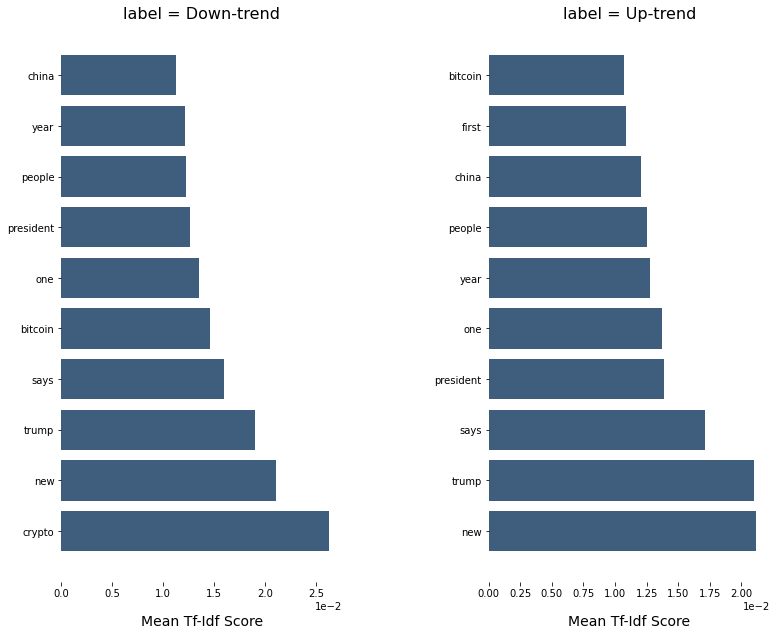

In [24]:
dfs = top_feats_by_class(Xtr, text_crypto_agg["label"].map({-1:"Down-trend", 1:"Up-trend"}), features, top_n=10)
plot_tfidf_classfeats_h(dfs)

### Bigram

In [25]:
vec_pipe = TfidfVectorizer(ngram_range=(2, 2), max_features=1000)
Xtr = vec_pipe.fit_transform(text_crypto_agg["title"])
features = vec_pipe.get_feature_names()

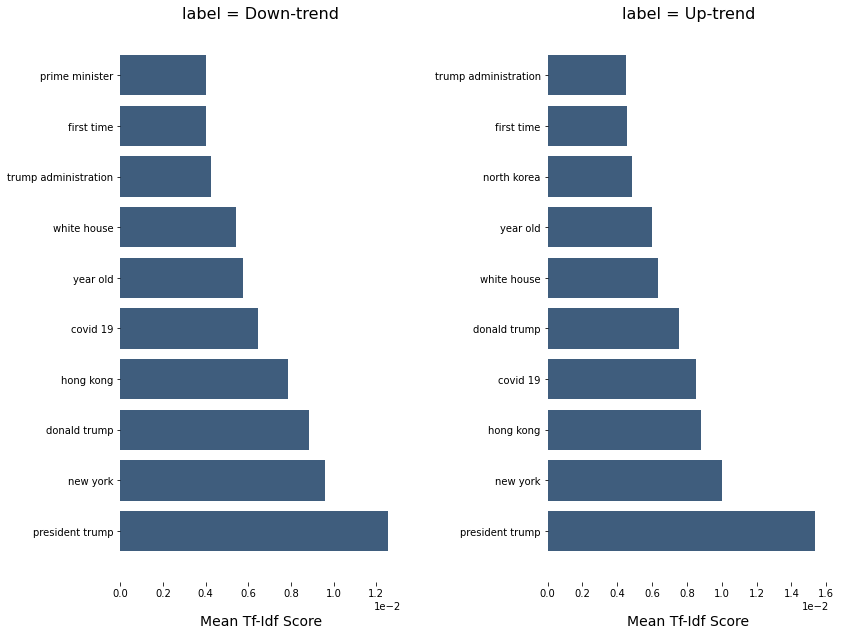

In [26]:
dfs = top_feats_by_class(Xtr, text_crypto_agg["label"].map({-1:"Down-trend", 1:"Up-trend"}), features, top_n=10)
plot_tfidf_classfeats_h(dfs)

### Trigram

In [27]:
vec_pipe = TfidfVectorizer(ngram_range=(3, 3), max_features=1000)
Xtr = vec_pipe.fit_transform(text_crypto_agg["title"])
features = vec_pipe.get_feature_names()

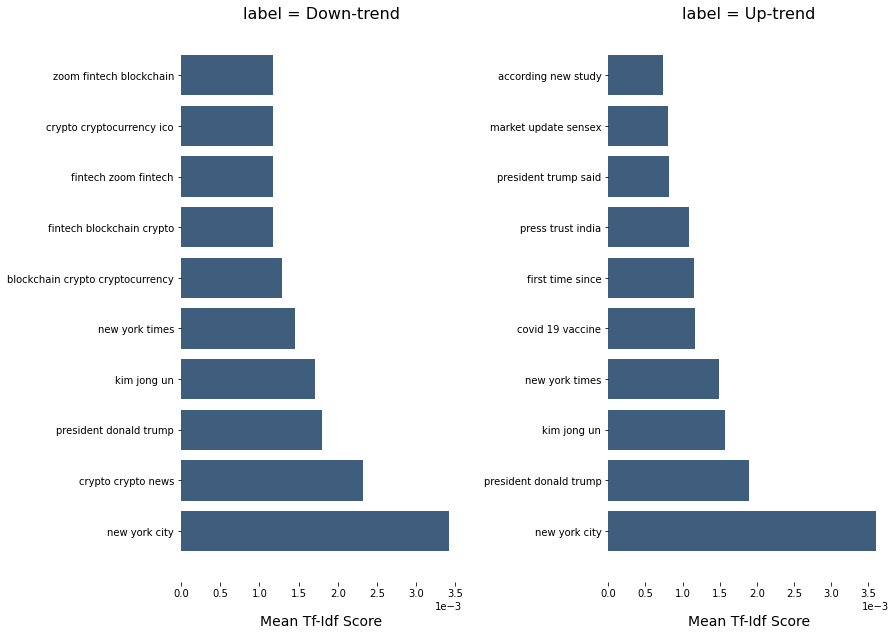

In [28]:
dfs = top_feats_by_class(Xtr, text_crypto_agg["label"].map({-1:"Down-trend", 1:"Up-trend"}), features, top_n=10)
plot_tfidf_classfeats_h(dfs)

## TextBlob Polarity

In [29]:
from textblob import TextBlob

text_crypto_agg['polarity'] = text_crypto_agg['title'].swifter.apply(lambda text: TextBlob(text).sentiment.polarity)

Pandas Apply:   0%|          | 0/1338472 [00:00<?, ?it/s]

In [30]:
text_crypto_agg.head()

,title,label,tokenised,length,polarity
date,,,,,
2014-09-17,billionaire bill koch fights fake wine hint pa...,-1.0,"[billionaire, bill, koch, fights, fake, wine, ...",10,-0.50
2014-09-17,breaking 319 108 vote u house representatives ...,-1.0,"[breaking, 319, 108, vote, u, house, represent...",13,0.00
2014-09-17,u aid syrian rebels stuffed bill also avoids g...,-1.0,"[u, aid, syrian, rebels, stuffed, bill, also, ...",11,0.00
2014-09-17,video iphone 6 review man small child like hands,-1.0,"[video, iphone, 6, review, man, small, child, ...",10,-0.25
2014-09-17,breaking 273 156 vote republican led house rep...,-1.0,"[breaking, 273, 156, vote, republican, led, ho...",14,0.00


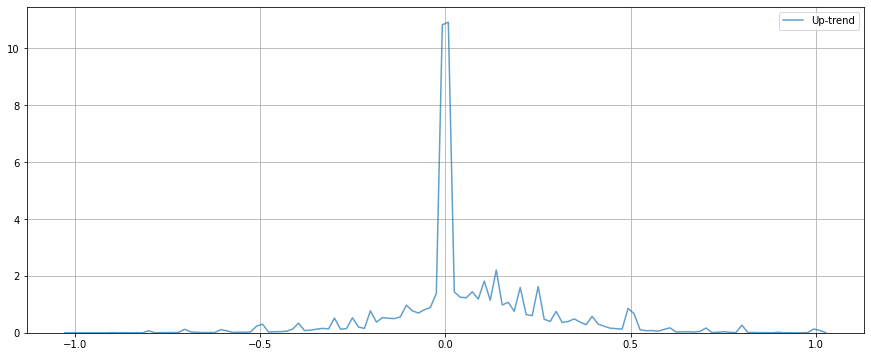

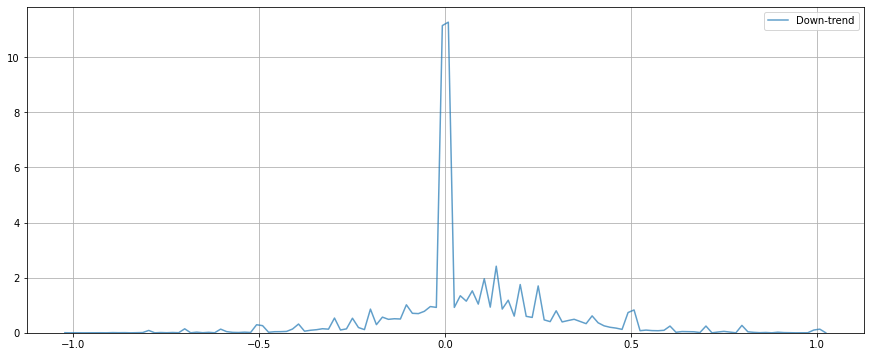

In [31]:
sns.kdeplot(text_crypto_agg.loc[text_crypto_agg.label==1, "polarity"], alpha=0.7, label="Up-trend")
plt.grid()
plt.show()

sns.kdeplot(text_crypto_agg.loc[text_crypto_agg.label==-1, "polarity"], alpha=0.7, label="Down-trend")
plt.grid()
plt.show()

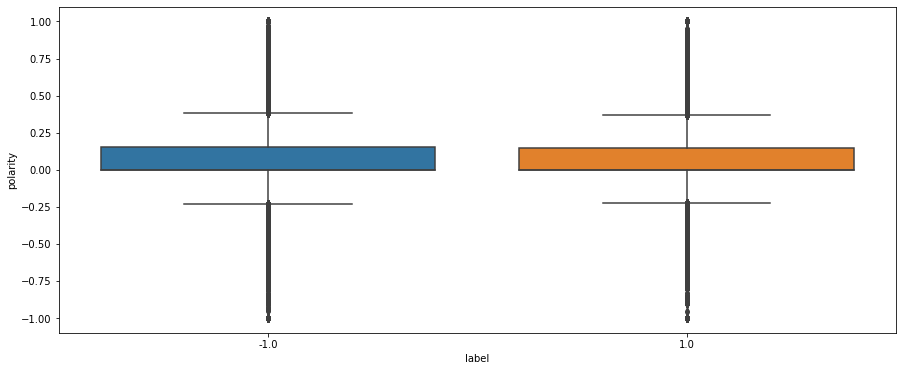

In [32]:
sns.boxplot(x="label", y="polarity", data=text_crypto_agg)
plt.show()

## Sentiment Dictionary

1. Two sentiment dictionaries:
 - Loughran and McDonald Sentiment Word Lists [website](https://sraf.nd.edu/textual-analysis/resources/)
 - Henry's (2008) Sentiment Word List [paper](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.1012.8936&rep=rep1&type=pdf)
2. Negation Rule: 
 - Any occurrence of negate words (e.g., isn't, not, never) within three words preceding a positive word will flip that positive word into a negative one.
 - Negation check only applies to positive words because Loughran and McDonald (2011) suggest that double negation (i.e., a negate word precedes a negative word) is not common.

### Sentiment Word Lists and Negation List

In [33]:
lmdict = {'Negative': ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abdicated',
                       'abdicates', 'abdicating', 'abdication', 'abdications', 'aberrant', 'aberration', 'aberrational',
                       'aberrations', 'abetting', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abolish',
                       'abolished', 'abolishes', 'abolishing', 'abrogate', 'abrogated', 'abrogates', 'abrogating',
                       'abrogation', 'abrogations', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absences',
                       'absenteeism', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'abusively', 'abusiveness',
                       'accident', 'accidental', 'accidentally', 'accidents', 'accusation', 'accusations', 'accuse',
                       'accused', 'accuses', 'accusing', 'acquiesce', 'acquiesced', 'acquiesces', 'acquiescing',
                       'acquit', 'acquits', 'acquittal', 'acquittals', 'acquitted', 'acquitting', 'adulterate',
                       'adulterated', 'adulterating', 'adulteration', 'adulterations', 'adversarial', 'adversaries',
                       'adversary', 'adverse', 'adversely', 'adversities', 'adversity', 'aftermath', 'aftermaths',
                       'against', 'aggravate', 'aggravated', 'aggravates', 'aggravating', 'aggravation', 'aggravations',
                       'alerted', 'alerting', 'alienate', 'alienated', 'alienates', 'alienating', 'alienation',
                       'alienations', 'allegation', 'allegations', 'allege', 'alleged', 'allegedly', 'alleges',
                       'alleging', 'annoy', 'annoyance', 'annoyances', 'annoyed', 'annoying', 'annoys', 'annul',
                       'annulled', 'annulling', 'annulment', 'annulments', 'annuls', 'anomalies', 'anomalous',
                       'anomalously', 'anomaly', 'anticompetitive', 'antitrust', 'argue', 'argued', 'arguing',
                       'argument', 'argumentative', 'arguments', 'arrearage', 'arrearages', 'arrears', 'arrest',
                       'arrested', 'arrests', 'artificially', 'assault', 'assaulted', 'assaulting', 'assaults',
                       'assertions', 'attrition', 'aversely', 'backdating', 'bad', 'bail', 'bailout', 'balk', 'balked',
                       'bankrupt', 'bankruptcies', 'bankruptcy', 'bankrupted', 'bankrupting', 'bankrupts', 'bans',
                       'barred', 'barrier', 'barriers', 'bottleneck', 'bottlenecks', 'boycott', 'boycotted',
                       'boycotting', 'boycotts', 'breach', 'breached', 'breaches', 'breaching', 'break', 'breakage',
                       'breakages', 'breakdown', 'breakdowns', 'breaking', 'breaks', 'bribe', 'bribed', 'briberies',
                       'bribery', 'bribes', 'bribing', 'bridge', 'broken', 'burden', 'burdened', 'burdening', 'burdens',
                       'burdensome', 'burned', 'calamities', 'calamitous', 'calamity', 'cancel', 'canceled',
                       'canceling', 'cancellation', 'cancellations', 'cancelled', 'cancelling', 'cancels', 'careless',
                       'carelessly', 'carelessness', 'catastrophe', 'catastrophes', 'catastrophic', 'catastrophically',
                       'caution', 'cautionary', 'cautioned', 'cautioning', 'cautions', 'cease', 'ceased', 'ceases',
                       'ceasing', 'censure', 'censured', 'censures', 'censuring', 'challenge', 'challenged',
                       'challenges', 'challenging', 'chargeoffs', 'circumvent', 'circumvented', 'circumventing',
                       'circumvention', 'circumventions', 'circumvents', 'claiming', 'claims', 'clawback', 'closed',
                       'closeout', 'closeouts', 'closing', 'closings', 'closure', 'closures', 'coerce', 'coerced',
                       'coerces', 'coercing', 'coercion', 'coercive', 'collapse', 'collapsed', 'collapses',
                       'collapsing', 'collision', 'collisions', 'collude', 'colluded', 'colludes', 'colluding',
                       'collusion', 'collusions', 'collusive', 'complain', 'complained', 'complaining', 'complains',
                       'complaint', 'complaints', 'complicate', 'complicated', 'complicates', 'complicating',
                       'complication', 'complications', 'compulsion', 'concealed', 'concealing', 'concede', 'conceded',
                       'concedes', 'conceding', 'concern', 'concerned', 'concerns', 'conciliating', 'conciliation',
                       'conciliations', 'condemn', 'condemnation', 'condemnations', 'condemned', 'condemning',
                       'condemns', 'condone', 'condoned', 'confess', 'confessed', 'confesses', 'confessing',
                       'confession', 'confine', 'confined', 'confinement', 'confinements', 'confines', 'confining',
                       'confiscate', 'confiscated', 'confiscates', 'confiscating', 'confiscation', 'confiscations',
                       'conflict', 'conflicted', 'conflicting', 'conflicts', 'confront', 'confrontation',
                       'confrontational', 'confrontations', 'confronted', 'confronting', 'confronts', 'confuse',
                       'confused', 'confuses', 'confusing', 'confusingly', 'confusion', 'conspiracies', 'conspiracy',
                       'conspirator', 'conspiratorial', 'conspirators', 'conspire', 'conspired', 'conspires',
                       'conspiring', 'contempt', 'contend', 'contended', 'contending', 'contends', 'contention',
                       'contentions', 'contentious', 'contentiously', 'contested', 'contesting', 'contraction',
                       'contractions', 'contradict', 'contradicted', 'contradicting', 'contradiction', 'contradictions',
                       'contradictory', 'contradicts', 'contrary', 'controversial', 'controversies', 'controversy',
                       'convict', 'convicted', 'convicting', 'conviction', 'convictions', 'corrected', 'correcting',
                       'correction', 'corrections', 'corrects', 'corrupt', 'corrupted', 'corrupting', 'corruption',
                       'corruptions', 'corruptly', 'corruptness', 'costly', 'counterclaim', 'counterclaimed',
                       'counterclaiming', 'counterclaims', 'counterfeit', 'counterfeited', 'counterfeiter',
                       'counterfeiters', 'counterfeiting', 'counterfeits', 'countermeasure', 'countermeasures', 'crime',
                       'crimes', 'criminal', 'criminally', 'criminals', 'crises', 'crisis', 'critical', 'critically',
                       'criticism', 'criticisms', 'criticize', 'criticized', 'criticizes', 'criticizing', 'crucial',
                       'crucially', 'culpability', 'culpable', 'culpably', 'cumbersome', 'curtail', 'curtailed',
                       'curtailing', 'curtailment', 'curtailments', 'curtails', 'cut', 'cutback', 'cutbacks',
                       'cyberattack', 'cyberattacks', 'cyberbullying', 'cybercrime', 'cybercrimes', 'cybercriminal',
                       'cybercriminals', 'damage', 'damaged', 'damages', 'damaging', 'dampen', 'dampened', 'danger',
                       'dangerous', 'dangerously', 'dangers', 'deadlock', 'deadlocked', 'deadlocking', 'deadlocks',
                       'deadweight', 'deadweights', 'debarment', 'debarments', 'debarred', 'deceased', 'deceit',
                       'deceitful', 'deceitfulness', 'deceive', 'deceived', 'deceives', 'deceiving', 'deception',
                       'deceptions', 'deceptive', 'deceptively', 'decline', 'declined', 'declines', 'declining',
                       'deface', 'defaced', 'defacement', 'defamation', 'defamations', 'defamatory', 'defame',
                       'defamed', 'defames', 'defaming', 'default', 'defaulted', 'defaulting', 'defaults', 'defeat',
                       'defeated', 'defeating', 'defeats', 'defect', 'defective', 'defects', 'defend', 'defendant',
                       'defendants', 'defended', 'defending', 'defends', 'defensive', 'defer', 'deficiencies',
                       'deficiency', 'deficient', 'deficit', 'deficits', 'defraud', 'defrauded', 'defrauding',
                       'defrauds', 'defunct', 'degradation', 'degradations', 'degrade', 'degraded', 'degrades',
                       'degrading', 'delay', 'delayed', 'delaying', 'delays', 'deleterious', 'deliberate',
                       'deliberated', 'deliberately', 'delinquencies', 'delinquency', 'delinquent', 'delinquently',
                       'delinquents', 'delist', 'delisted', 'delisting', 'delists', 'demise', 'demised', 'demises',
                       'demising', 'demolish', 'demolished', 'demolishes', 'demolishing', 'demolition', 'demolitions',
                       'demote', 'demoted', 'demotes', 'demoting', 'demotion', 'demotions', 'denial', 'denials',
                       'denied', 'denies', 'denigrate', 'denigrated', 'denigrates', 'denigrating', 'denigration',
                       'deny', 'denying', 'deplete', 'depleted', 'depletes', 'depleting', 'depletion', 'depletions',
                       'deprecation', 'depress', 'depressed', 'depresses', 'depressing', 'deprivation', 'deprive',
                       'deprived', 'deprives', 'depriving', 'derelict', 'dereliction', 'derogatory', 'destabilization',
                       'destabilize', 'destabilized', 'destabilizing', 'destroy', 'destroyed', 'destroying', 'destroys',
                       'destruction', 'destructive', 'detain', 'detained', 'detention', 'detentions', 'deter',
                       'deteriorate', 'deteriorated', 'deteriorates', 'deteriorating', 'deterioration',
                       'deteriorations', 'deterred', 'deterrence', 'deterrences', 'deterrent', 'deterrents',
                       'deterring', 'deters', 'detract', 'detracted', 'detracting', 'detriment', 'detrimental',
                       'detrimentally', 'detriments', 'devalue', 'devalued', 'devalues', 'devaluing', 'devastate',
                       'devastated', 'devastating', 'devastation', 'deviate', 'deviated', 'deviates', 'deviating',
                       'deviation', 'deviations', 'devolve', 'devolved', 'devolves', 'devolving', 'difficult',
                       'difficulties', 'difficultly', 'difficulty', 'diminish', 'diminished', 'diminishes',
                       'diminishing', 'diminution', 'disadvantage', 'disadvantaged', 'disadvantageous', 'disadvantages',
                       'disaffiliation', 'disagree', 'disagreeable', 'disagreed', 'disagreeing', 'disagreement',
                       'disagreements', 'disagrees', 'disallow', 'disallowance', 'disallowances', 'disallowed',
                       'disallowing', 'disallows', 'disappear', 'disappearance', 'disappearances', 'disappeared',
                       'disappearing', 'disappears', 'disappoint', 'disappointed', 'disappointing', 'disappointingly',
                       'disappointment', 'disappointments', 'disappoints', 'disapproval', 'disapprovals', 'disapprove',
                       'disapproved', 'disapproves', 'disapproving', 'disassociates', 'disassociating',
                       'disassociation', 'disassociations', 'disaster', 'disasters', 'disastrous', 'disastrously',
                       'disavow', 'disavowal', 'disavowed', 'disavowing', 'disavows', 'disciplinary', 'disclaim',
                       'disclaimed', 'disclaimer', 'disclaimers', 'disclaiming', 'disclaims', 'disclose', 'disclosed',
                       'discloses', 'disclosing', 'discontinuance', 'discontinuances', 'discontinuation',
                       'discontinuations', 'discontinue', 'discontinued', 'discontinues', 'discontinuing', 'discourage',
                       'discouraged', 'discourages', 'discouraging', 'discredit', 'discredited', 'discrediting',
                       'discredits', 'discrepancies', 'discrepancy', 'disfavor', 'disfavored', 'disfavoring',
                       'disfavors', 'disgorge', 'disgorged', 'disgorgement', 'disgorgements', 'disgorges', 'disgorging',
                       'disgrace', 'disgraceful', 'disgracefully', 'dishonest', 'dishonestly', 'dishonesty', 'dishonor',
                       'dishonorable', 'dishonorably', 'dishonored', 'dishonoring', 'dishonors', 'disincentives',
                       'disinterested', 'disinterestedly', 'disinterestedness', 'disloyal', 'disloyally', 'disloyalty',
                       'dismal', 'dismally', 'dismiss', 'dismissal', 'dismissals', 'dismissed', 'dismisses',
                       'dismissing', 'disorderly', 'disparage', 'disparaged', 'disparagement', 'disparagements',
                       'disparages', 'disparaging', 'disparagingly', 'disparities', 'disparity', 'displace',
                       'displaced', 'displacement', 'displacements', 'displaces', 'displacing', 'dispose', 'dispossess',
                       'dispossessed', 'dispossesses', 'dispossessing', 'disproportion', 'disproportional',
                       'disproportionate', 'disproportionately', 'dispute', 'disputed', 'disputes', 'disputing',
                       'disqualification', 'disqualifications', 'disqualified', 'disqualifies', 'disqualify',
                       'disqualifying', 'disregard', 'disregarded', 'disregarding', 'disregards', 'disreputable',
                       'disrepute', 'disrupt', 'disrupted', 'disrupting', 'disruption', 'disruptions', 'disruptive',
                       'disrupts', 'dissatisfaction', 'dissatisfied', 'dissent', 'dissented', 'dissenter', 'dissenters',
                       'dissenting', 'dissents', 'dissident', 'dissidents', 'dissolution', 'dissolutions', 'distort',
                       'distorted', 'distorting', 'distortion', 'distortions', 'distorts', 'distract', 'distracted',
                       'distracting', 'distraction', 'distractions', 'distracts', 'distress', 'distressed', 'disturb',
                       'disturbance', 'disturbances', 'disturbed', 'disturbing', 'disturbs', 'diversion', 'divert',
                       'diverted', 'diverting', 'diverts', 'divest', 'divested', 'divesting', 'divestiture',
                       'divestitures', 'divestment', 'divestments', 'divests', 'divorce', 'divorced', 'divulge',
                       'divulged', 'divulges', 'divulging', 'doubt', 'doubted', 'doubtful', 'doubts', 'downgrade',
                       'downgraded', 'downgrades', 'downgrading', 'downsize', 'downsized', 'downsizes', 'downsizing',
                       'downsizings', 'downtime', 'downtimes', 'downturn', 'downturns', 'downward', 'downwards', 'drag',
                       'drastic', 'drastically', 'drawback', 'drawbacks', 'dropped', 'drought', 'droughts', 'duress',
                       'dysfunction', 'dysfunctional', 'dysfunctions', 'easing', 'egregious', 'egregiously', 'embargo',
                       'embargoed', 'embargoes', 'embargoing', 'embarrass', 'embarrassed', 'embarrasses',
                       'embarrassing', 'embarrassment', 'embarrassments', 'embezzle', 'embezzled', 'embezzlement',
                       'embezzlements', 'embezzler', 'embezzles', 'embezzling', 'encroach', 'encroached', 'encroaches',
                       'encroaching', 'encroachment', 'encroachments', 'encumber', 'encumbered', 'encumbering',
                       'encumbers', 'encumbrance', 'encumbrances', 'endanger', 'endangered', 'endangering',
                       'endangerment', 'endangers', 'enjoin', 'enjoined', 'enjoining', 'enjoins', 'erode', 'eroded',
                       'erodes', 'eroding', 'erosion', 'erratic', 'erratically', 'erred', 'erring', 'erroneous',
                       'erroneously', 'error', 'errors', 'errs', 'escalate', 'escalated', 'escalates', 'escalating',
                       'evade', 'evaded', 'evades', 'evading', 'evasion', 'evasions', 'evasive', 'evict', 'evicted',
                       'evicting', 'eviction', 'evictions', 'evicts', 'exacerbate', 'exacerbated', 'exacerbates',
                       'exacerbating', 'exacerbation', 'exacerbations', 'exaggerate', 'exaggerated', 'exaggerates',
                       'exaggerating', 'exaggeration', 'excessive', 'excessively', 'exculpate', 'exculpated',
                       'exculpates', 'exculpating', 'exculpation', 'exculpations', 'exculpatory', 'exonerate',
                       'exonerated', 'exonerates', 'exonerating', 'exoneration', 'exonerations', 'exploit',
                       'exploitation', 'exploitations', 'exploitative', 'exploited', 'exploiting', 'exploits', 'expose',
                       'exposed', 'exposes', 'exposing', 'expropriate', 'expropriated', 'expropriates', 'expropriating',
                       'expropriation', 'expropriations', 'expulsion', 'expulsions', 'extenuating', 'fail', 'failed',
                       'failing', 'failings', 'fails', 'failure', 'failures', 'fallout', 'false', 'falsely',
                       'falsification', 'falsifications', 'falsified', 'falsifies', 'falsify', 'falsifying', 'falsity',
                       'fatalities', 'fatality', 'fatally', 'fault', 'faulted', 'faults', 'faulty', 'fear', 'fears',
                       'felonies', 'felonious', 'felony', 'fictitious', 'fined', 'fines', 'fired', 'firing', 'flaw',
                       'flawed', 'flaws', 'forbid', 'forbidden', 'forbidding', 'forbids', 'force', 'forced', 'forcing',
                       'foreclose', 'foreclosed', 'forecloses', 'foreclosing', 'foreclosure', 'foreclosures', 'forego',
                       'foregoes', 'foregone', 'forestall', 'forestalled', 'forestalling', 'forestalls', 'forfeit',
                       'forfeited', 'forfeiting', 'forfeits', 'forfeiture', 'forfeitures', 'forgers', 'forgery',
                       'fraud', 'frauds', 'fraudulence', 'fraudulent', 'fraudulently', 'frivolous', 'frivolously',
                       'frustrate', 'frustrated', 'frustrates', 'frustrating', 'frustratingly', 'frustration',
                       'frustrations', 'fugitive', 'fugitives', 'gratuitous', 'gratuitously', 'grievance', 'grievances',
                       'grossly', 'groundless', 'guilty', 'halt', 'halted', 'hamper', 'hampered', 'hampering',
                       'hampers', 'harass', 'harassed', 'harassing', 'harassment', 'hardship', 'hardships', 'harm',
                       'harmed', 'harmful', 'harmfully', 'harming', 'harms', 'harsh', 'harsher', 'harshest', 'harshly',
                       'harshness', 'hazard', 'hazardous', 'hazards', 'hinder', 'hindered', 'hindering', 'hinders',
                       'hindrance', 'hindrances', 'hostile', 'hostility', 'hurt', 'hurting', 'idle', 'idled', 'idling',
                       'ignore', 'ignored', 'ignores', 'ignoring', 'ill', 'illegal', 'illegalities', 'illegality',
                       'illegally', 'illegible', 'illicit', 'illicitly', 'illiquid', 'illiquidity', 'imbalance',
                       'imbalances', 'immature', 'immoral', 'impair', 'impaired', 'impairing', 'impairment',
                       'impairments', 'impairs', 'impasse', 'impasses', 'impede', 'impeded', 'impedes', 'impediment',
                       'impediments', 'impeding', 'impending', 'imperative', 'imperfection', 'imperfections', 'imperil',
                       'impermissible', 'implicate', 'implicated', 'implicates', 'implicating', 'impossibility',
                       'impossible', 'impound', 'impounded', 'impounding', 'impounds', 'impracticable', 'impractical',
                       'impracticalities', 'impracticality', 'imprisonment', 'improper', 'improperly', 'improprieties',
                       'impropriety', 'imprudent', 'imprudently', 'inability', 'inaccessible', 'inaccuracies',
                       'inaccuracy', 'inaccurate', 'inaccurately', 'inaction', 'inactions', 'inactivate', 'inactivated',
                       'inactivates', 'inactivating', 'inactivation', 'inactivations', 'inactivity', 'inadequacies',
                       'inadequacy', 'inadequate', 'inadequately', 'inadvertent', 'inadvertently', 'inadvisability',
                       'inadvisable', 'inappropriate', 'inappropriately', 'inattention', 'incapable', 'incapacitated',
                       'incapacity', 'incarcerate', 'incarcerated', 'incarcerates', 'incarcerating', 'incarceration',
                       'incarcerations', 'incidence', 'incidences', 'incident', 'incidents', 'incompatibilities',
                       'incompatibility', 'incompatible', 'incompetence', 'incompetency', 'incompetent',
                       'incompetently', 'incompetents', 'incomplete', 'incompletely', 'incompleteness', 'inconclusive',
                       'inconsistencies', 'inconsistency', 'inconsistent', 'inconsistently', 'inconvenience',
                       'inconveniences', 'inconvenient', 'incorrect', 'incorrectly', 'incorrectness', 'indecency',
                       'indecent', 'indefeasible', 'indefeasibly', 'indict', 'indictable', 'indicted', 'indicting',
                       'indictment', 'indictments', 'ineffective', 'ineffectively', 'ineffectiveness', 'inefficiencies',
                       'inefficiency', 'inefficient', 'inefficiently', 'ineligibility', 'ineligible', 'inequitable',
                       'inequitably', 'inequities', 'inequity', 'inevitable', 'inexperience', 'inexperienced',
                       'inferior', 'inflicted', 'infraction', 'infractions', 'infringe', 'infringed', 'infringement',
                       'infringements', 'infringes', 'infringing', 'inhibited', 'inimical', 'injunction', 'injunctions',
                       'injure', 'injured', 'injures', 'injuries', 'injuring', 'injurious', 'injury', 'inordinate',
                       'inordinately', 'inquiry', 'insecure', 'insensitive', 'insolvencies', 'insolvency', 'insolvent',
                       'instability', 'insubordination', 'insufficiency', 'insufficient', 'insufficiently',
                       'insurrection', 'insurrections', 'intentional', 'interfere', 'interfered', 'interference',
                       'interferences', 'interferes', 'interfering', 'intermittent', 'intermittently', 'interrupt',
                       'interrupted', 'interrupting', 'interruption', 'interruptions', 'interrupts', 'intimidation',
                       'intrusion', 'invalid', 'invalidate', 'invalidated', 'invalidates', 'invalidating',
                       'invalidation', 'invalidity', 'investigate', 'investigated', 'investigates', 'investigating',
                       'investigation', 'investigations', 'involuntarily', 'involuntary', 'irreconcilable',
                       'irreconcilably', 'irrecoverable', 'irrecoverably', 'irregular', 'irregularities',
                       'irregularity', 'irregularly', 'irreparable', 'irreparably', 'irreversible', 'jeopardize',
                       'jeopardized', 'justifiable', 'kickback', 'kickbacks', 'knowingly', 'lack', 'lacked', 'lacking',
                       'lackluster', 'lacks', 'lag', 'lagged', 'lagging', 'lags', 'lapse', 'lapsed', 'lapses',
                       'lapsing', 'late', 'laundering', 'layoff', 'layoffs', 'lie', 'limitation', 'limitations',
                       'lingering', 'liquidate', 'liquidated', 'liquidates', 'liquidating', 'liquidation',
                       'liquidations', 'liquidator', 'liquidators', 'litigant', 'litigants', 'litigate', 'litigated',
                       'litigates', 'litigating', 'litigation', 'litigations', 'lockout', 'lockouts', 'lose', 'loses',
                       'losing', 'loss', 'losses', 'lost', 'lying', 'malfeasance', 'malfunction', 'malfunctioned',
                       'malfunctioning', 'malfunctions', 'malice', 'malicious', 'maliciously', 'malpractice',
                       'manipulate', 'manipulated', 'manipulates', 'manipulating', 'manipulation', 'manipulations',
                       'manipulative', 'markdown', 'markdowns', 'misapplication', 'misapplications', 'misapplied',
                       'misapplies', 'misapply', 'misapplying', 'misappropriate', 'misappropriated', 'misappropriates',
                       'misappropriating', 'misappropriation', 'misappropriations', 'misbranded', 'miscalculate',
                       'miscalculated', 'miscalculates', 'miscalculating', 'miscalculation', 'miscalculations',
                       'mischaracterization', 'mischief', 'misclassification', 'misclassifications', 'misclassified',
                       'misclassify', 'miscommunication', 'misconduct', 'misdated', 'misdemeanor', 'misdemeanors',
                       'misdirected', 'mishandle', 'mishandled', 'mishandles', 'mishandling', 'misinform',
                       'misinformation', 'misinformed', 'misinforming', 'misinforms', 'misinterpret',
                       'misinterpretation', 'misinterpretations', 'misinterpreted', 'misinterpreting', 'misinterprets',
                       'misjudge', 'misjudged', 'misjudges', 'misjudging', 'misjudgment', 'misjudgments', 'mislabel',
                       'mislabeled', 'mislabeling', 'mislabelled', 'mislabels', 'mislead', 'misleading', 'misleadingly',
                       'misleads', 'misled', 'mismanage', 'mismanaged', 'mismanagement', 'mismanages', 'mismanaging',
                       'mismatch', 'mismatched', 'mismatches', 'mismatching', 'misplaced', 'misprice', 'mispricing',
                       'mispricings', 'misrepresent', 'misrepresentation', 'misrepresentations', 'misrepresented',
                       'misrepresenting', 'misrepresents', 'miss', 'missed', 'misses', 'misstate', 'misstated',
                       'misstatement', 'misstatements', 'misstates', 'misstating', 'misstep', 'missteps', 'mistake',
                       'mistaken', 'mistakenly', 'mistakes', 'mistaking', 'mistrial', 'mistrials', 'misunderstand',
                       'misunderstanding', 'misunderstandings', 'misunderstood', 'misuse', 'misused', 'misuses',
                       'misusing', 'monopolistic', 'monopolists', 'monopolization', 'monopolize', 'monopolized',
                       'monopolizes', 'monopolizing', 'monopoly', 'moratoria', 'moratorium', 'moratoriums',
                       'mothballed', 'mothballing', 'negative', 'negatively', 'negatives', 'neglect', 'neglected',
                       'neglectful', 'neglecting', 'neglects', 'negligence', 'negligences', 'negligent', 'negligently',
                       'nonattainment', 'noncompetitive', 'noncompliance', 'noncompliances', 'noncompliant',
                       'noncomplying', 'nonconforming', 'nonconformities', 'nonconformity', 'nondisclosure',
                       'nonfunctional', 'nonpayment', 'nonpayments', 'nonperformance', 'nonperformances',
                       'nonperforming', 'nonproducing', 'nonproductive', 'nonrecoverable', 'nonrenewal', 'nuisance',
                       'nuisances', 'nullification', 'nullifications', 'nullified', 'nullifies', 'nullify',
                       'nullifying', 'objected', 'objecting', 'objection', 'objectionable', 'objectionably',
                       'objections', 'obscene', 'obscenity', 'obsolescence', 'obsolete', 'obstacle', 'obstacles',
                       'obstruct', 'obstructed', 'obstructing', 'obstruction', 'obstructions', 'offence', 'offences',
                       'offend', 'offended', 'offender', 'offenders', 'offending', 'offends', 'omission', 'omissions',
                       'omit', 'omits', 'omitted', 'omitting', 'onerous', 'opportunistic', 'opportunistically',
                       'oppose', 'opposed', 'opposes', 'opposing', 'opposition', 'oppositions', 'outage', 'outages',
                       'outdated', 'outmoded', 'overage', 'overages', 'overbuild', 'overbuilding', 'overbuilds',
                       'overbuilt', 'overburden', 'overburdened', 'overburdening', 'overcapacities', 'overcapacity',
                       'overcharge', 'overcharged', 'overcharges', 'overcharging', 'overcome', 'overcomes',
                       'overcoming', 'overdue', 'overestimate', 'overestimated', 'overestimates', 'overestimating',
                       'overestimation', 'overestimations', 'overload', 'overloaded', 'overloading', 'overloads',
                       'overlook', 'overlooked', 'overlooking', 'overlooks', 'overpaid', 'overpayment', 'overpayments',
                       'overproduced', 'overproduces', 'overproducing', 'overproduction', 'overrun', 'overrunning',
                       'overruns', 'overshadow', 'overshadowed', 'overshadowing', 'overshadows', 'overstate',
                       'overstated', 'overstatement', 'overstatements', 'overstates', 'overstating', 'oversupplied',
                       'oversupplies', 'oversupply', 'oversupplying', 'overtly', 'overturn', 'overturned',
                       'overturning', 'overturns', 'overvalue', 'overvalued', 'overvaluing', 'panic', 'panics',
                       'penalize', 'penalized', 'penalizes', 'penalizing', 'penalties', 'penalty', 'peril', 'perils',
                       'perjury', 'perpetrate', 'perpetrated', 'perpetrates', 'perpetrating', 'perpetration', 'persist',
                       'persisted', 'persistence', 'persistent', 'persistently', 'persisting', 'persists', 'pervasive',
                       'pervasively', 'pervasiveness', 'petty', 'picket', 'picketed', 'picketing', 'plaintiff',
                       'plaintiffs', 'plea', 'plead', 'pleaded', 'pleading', 'pleadings', 'pleads', 'pleas', 'pled',
                       'poor', 'poorly', 'poses', 'posing', 'postpone', 'postponed', 'postponement', 'postponements',
                       'postpones', 'postponing', 'precipitated', 'precipitous', 'precipitously', 'preclude',
                       'precluded', 'precludes', 'precluding', 'predatory', 'prejudice', 'prejudiced', 'prejudices',
                       'prejudicial', 'prejudicing', 'premature', 'prematurely', 'pressing', 'pretrial', 'preventing',
                       'prevention', 'prevents', 'problem', 'problematic', 'problematical', 'problems', 'prolong',
                       'prolongation', 'prolongations', 'prolonged', 'prolonging', 'prolongs', 'prone', 'prosecute',
                       'prosecuted', 'prosecutes', 'prosecuting', 'prosecution', 'prosecutions', 'protest', 'protested',
                       'protester', 'protesters', 'protesting', 'protestor', 'protestors', 'protests', 'protracted',
                       'protraction', 'provoke', 'provoked', 'provokes', 'provoking', 'punished', 'punishes',
                       'punishing', 'punishment', 'punishments', 'punitive', 'purport', 'purported', 'purportedly',
                       'purporting', 'purports', 'question', 'questionable', 'questionably', 'questioned',
                       'questioning', 'questions', 'quit', 'quitting', 'racketeer', 'racketeering', 'rationalization',
                       'rationalizations', 'rationalize', 'rationalized', 'rationalizes', 'rationalizing',
                       'reassessment', 'reassessments', 'reassign', 'reassigned', 'reassigning', 'reassignment',
                       'reassignments', 'reassigns', 'recall', 'recalled', 'recalling', 'recalls', 'recession',
                       'recessionary', 'recessions', 'reckless', 'recklessly', 'recklessness', 'redact', 'redacted',
                       'redacting', 'redaction', 'redactions', 'redefault', 'redefaulted', 'redefaults', 'redress',
                       'redressed', 'redresses', 'redressing', 'refusal', 'refusals', 'refuse', 'refused', 'refuses',
                       'refusing', 'reject', 'rejected', 'rejecting', 'rejection', 'rejections', 'rejects',
                       'relinquish', 'relinquished', 'relinquishes', 'relinquishing', 'relinquishment',
                       'relinquishments', 'reluctance', 'reluctant', 'renegotiate', 'renegotiated', 'renegotiates',
                       'renegotiating', 'renegotiation', 'renegotiations', 'renounce', 'renounced', 'renouncement',
                       'renouncements', 'renounces', 'renouncing', 'reparation', 'reparations', 'repossessed',
                       'repossesses', 'repossessing', 'repossession', 'repossessions', 'repudiate', 'repudiated',
                       'repudiates', 'repudiating', 'repudiation', 'repudiations', 'resign', 'resignation',
                       'resignations', 'resigned', 'resigning', 'resigns', 'restate', 'restated', 'restatement',
                       'restatements', 'restates', 'restating', 'restructure', 'restructured', 'restructures',
                       'restructuring', 'restructurings', 'retaliate', 'retaliated', 'retaliates', 'retaliating',
                       'retaliation', 'retaliations', 'retaliatory', 'retribution', 'retributions', 'revocation',
                       'revocations', 'revoke', 'revoked', 'revokes', 'revoking', 'ridicule', 'ridiculed', 'ridicules',
                       'ridiculing', 'riskier', 'riskiest', 'risky', 'sabotage', 'sacrifice', 'sacrificed',
                       'sacrifices', 'sacrificial', 'sacrificing', 'scandalous', 'scandals', 'scrutinize',
                       'scrutinized', 'scrutinizes', 'scrutinizing', 'scrutiny', 'secrecy', 'seize', 'seized', 'seizes',
                       'seizing', 'sentenced', 'sentencing', 'serious', 'seriously', 'seriousness', 'setback',
                       'setbacks', 'sever', 'severe', 'severed', 'severely', 'severities', 'severity', 'sharply',
                       'shocked', 'shortage', 'shortages', 'shortfall', 'shortfalls', 'shrinkage', 'shrinkages', 'shut',
                       'shutdown', 'shutdowns', 'shuts', 'shutting', 'slander', 'slandered', 'slanderous', 'slanders',
                       'slippage', 'slippages', 'slow', 'slowdown', 'slowdowns', 'slowed', 'slower', 'slowest',
                       'slowing', 'slowly', 'slowness', 'sluggish', 'sluggishly', 'sluggishness', 'solvencies',
                       'solvency', 'spam', 'spammers', 'spamming', 'staggering', 'stagnant', 'stagnate', 'stagnated',
                       'stagnates', 'stagnating', 'stagnation', 'standstill', 'standstills', 'stolen', 'stoppage',
                       'stoppages', 'stopped', 'stopping', 'stops', 'strain', 'strained', 'straining', 'strains',
                       'stress', 'stressed', 'stresses', 'stressful', 'stressing', 'stringent', 'subjected',
                       'subjecting', 'subjection', 'subpoena', 'subpoenaed', 'subpoenas', 'substandard', 'sue', 'sued',
                       'sues', 'suffer', 'suffered', 'suffering', 'suffers', 'suing', 'summoned', 'summoning',
                       'summons', 'summonses', 'susceptibility', 'susceptible', 'suspect', 'suspected', 'suspects',
                       'suspend', 'suspended', 'suspending', 'suspends', 'suspension', 'suspensions', 'suspicion',
                       'suspicions', 'suspicious', 'suspiciously', 'taint', 'tainted', 'tainting', 'taints', 'tampered',
                       'tense', 'terminate', 'terminated', 'terminates', 'terminating', 'termination', 'terminations',
                       'testify', 'testifying', 'threat', 'threaten', 'threatened', 'threatening', 'threatens',
                       'threats', 'tightening', 'tolerate', 'tolerated', 'tolerates', 'tolerating', 'toleration',
                       'tortuous', 'tortuously', 'tragedies', 'tragedy', 'tragic', 'tragically', 'traumatic', 'trouble',
                       'troubled', 'troubles', 'turbulence', 'turmoil', 'unable', 'unacceptable', 'unacceptably',
                       'unaccounted', 'unannounced', 'unanticipated', 'unapproved', 'unattractive', 'unauthorized',
                       'unavailability', 'unavailable', 'unavoidable', 'unavoidably', 'unaware', 'uncollectable',
                       'uncollected', 'uncollectibility', 'uncollectible', 'uncollectibles', 'uncompetitive',
                       'uncompleted', 'unconscionable', 'unconscionably', 'uncontrollable', 'uncontrollably',
                       'uncontrolled', 'uncorrected', 'uncover', 'uncovered', 'uncovering', 'uncovers', 'undeliverable',
                       'undelivered', 'undercapitalized', 'undercut', 'undercuts', 'undercutting', 'underestimate',
                       'underestimated', 'underestimates', 'underestimating', 'underestimation', 'underfunded',
                       'underinsured', 'undermine', 'undermined', 'undermines', 'undermining', 'underpaid',
                       'underpayment', 'underpayments', 'underpays', 'underperform', 'underperformance',
                       'underperformed', 'underperforming', 'underperforms', 'underproduced', 'underproduction',
                       'underreporting', 'understate', 'understated', 'understatement', 'understatements',
                       'understates', 'understating', 'underutilization', 'underutilized', 'undesirable', 'undesired',
                       'undetected', 'undetermined', 'undisclosed', 'undocumented', 'undue', 'unduly', 'uneconomic',
                       'uneconomical', 'uneconomically', 'unemployed', 'unemployment', 'unethical', 'unethically',
                       'unexcused', 'unexpected', 'unexpectedly', 'unfair', 'unfairly', 'unfavorability', 'unfavorable',
                       'unfavorably', 'unfavourable', 'unfeasible', 'unfit', 'unfitness', 'unforeseeable', 'unforeseen',
                       'unforseen', 'unfortunate', 'unfortunately', 'unfounded', 'unfriendly', 'unfulfilled',
                       'unfunded', 'uninsured', 'unintended', 'unintentional', 'unintentionally', 'unjust',
                       'unjustifiable', 'unjustifiably', 'unjustified', 'unjustly', 'unknowing', 'unknowingly',
                       'unlawful', 'unlawfully', 'unlicensed', 'unliquidated', 'unmarketable', 'unmerchantable',
                       'unmeritorious', 'unnecessarily', 'unnecessary', 'unneeded', 'unobtainable', 'unoccupied',
                       'unpaid', 'unperformed', 'unplanned', 'unpopular', 'unpredictability', 'unpredictable',
                       'unpredictably', 'unpredicted', 'unproductive', 'unprofitability', 'unprofitable', 'unqualified',
                       'unrealistic', 'unreasonable', 'unreasonableness', 'unreasonably', 'unreceptive',
                       'unrecoverable', 'unrecovered', 'unreimbursed', 'unreliable', 'unremedied', 'unreported',
                       'unresolved', 'unrest', 'unsafe', 'unsalable', 'unsaleable', 'unsatisfactory', 'unsatisfied',
                       'unsavory', 'unscheduled', 'unsellable', 'unsold', 'unsound', 'unstabilized', 'unstable',
                       'unsubstantiated', 'unsuccessful', 'unsuccessfully', 'unsuitability', 'unsuitable', 'unsuitably',
                       'unsuited', 'unsure', 'unsuspected', 'unsuspecting', 'unsustainable', 'untenable', 'untimely',
                       'untrusted', 'untruth', 'untruthful', 'untruthfully', 'untruthfulness', 'untruths', 'unusable',
                       'unwanted', 'unwarranted', 'unwelcome', 'unwilling', 'unwillingness', 'upset', 'urgency',
                       'urgent', 'usurious', 'usurp', 'usurped', 'usurping', 'usurps', 'usury', 'vandalism', 'verdict',
                       'verdicts', 'vetoed', 'victims', 'violate', 'violated', 'violates', 'violating', 'violation',
                       'violations', 'violative', 'violator', 'violators', 'violence', 'violent', 'violently',
                       'vitiate', 'vitiated', 'vitiates', 'vitiating', 'vitiation', 'voided', 'voiding', 'volatile',
                       'volatility', 'vulnerabilities', 'vulnerability', 'vulnerable', 'vulnerably', 'warn', 'warned',
                       'warning', 'warnings', 'warns', 'wasted', 'wasteful', 'wasting', 'weak', 'weaken', 'weakened',
                       'weakening', 'weakens', 'weaker', 'weakest', 'weakly', 'weakness', 'weaknesses', 'willfully',
                       'worries', 'worry', 'worrying', 'worse', 'worsen', 'worsened', 'worsening', 'worsens', 'worst',
                       'worthless', 'writedown', 'writedowns', 'writeoff', 'writeoffs', 'wrong', 'wrongdoing',
                       'wrongdoings', 'wrongful', 'wrongfully', 'wrongly'],
          'Positive': ['able', 'abundance', 'abundant', 'acclaimed', 'accomplish', 'accomplished', 'accomplishes',
                       'accomplishing', 'accomplishment', 'accomplishments', 'achieve', 'achieved', 'achievement',
                       'achievements', 'achieves', 'achieving', 'adequately', 'advancement', 'advancements', 'advances',
                       'advancing', 'advantage', 'advantaged', 'advantageous', 'advantageously', 'advantages',
                       'alliance', 'alliances', 'assure', 'assured', 'assures', 'assuring', 'attain', 'attained',
                       'attaining', 'attainment', 'attainments', 'attains', 'attractive', 'attractiveness', 'beautiful',
                       'beautifully', 'beneficial', 'beneficially', 'benefit', 'benefited', 'benefiting', 'benefitted',
                       'benefitting', 'best', 'better', 'bolstered', 'bolstering', 'bolsters', 'boom', 'booming',
                       'boost', 'boosted', 'breakthrough', 'breakthroughs', 'brilliant', 'charitable', 'collaborate',
                       'collaborated', 'collaborates', 'collaborating', 'collaboration', 'collaborations',
                       'collaborative', 'collaborator', 'collaborators', 'compliment', 'complimentary', 'complimented',
                       'complimenting', 'compliments', 'conclusive', 'conclusively', 'conducive', 'confident',
                       'constructive', 'constructively', 'courteous', 'creative', 'creatively', 'creativeness',
                       'creativity', 'delight', 'delighted', 'delightful', 'delightfully', 'delighting', 'delights',
                       'dependability', 'dependable', 'desirable', 'desired', 'despite', 'destined', 'diligent',
                       'diligently', 'distinction', 'distinctions', 'distinctive', 'distinctively', 'distinctiveness',
                       'dream', 'easier', 'easily', 'easy', 'effective', 'efficiencies', 'efficiency', 'efficient',
                       'efficiently', 'empower', 'empowered', 'empowering', 'empowers', 'enable', 'enabled', 'enables',
                       'enabling', 'encouraged', 'encouragement', 'encourages', 'encouraging', 'enhance', 'enhanced',
                       'enhancement', 'enhancements', 'enhances', 'enhancing', 'enjoy', 'enjoyable', 'enjoyably',
                       'enjoyed', 'enjoying', 'enjoyment', 'enjoys', 'enthusiasm', 'enthusiastic', 'enthusiastically',
                       'excellence', 'excellent', 'excelling', 'excels', 'exceptional', 'exceptionally', 'excited',
                       'excitement', 'exciting', 'exclusive', 'exclusively', 'exclusiveness', 'exclusives',
                       'exclusivity', 'exemplary', 'fantastic', 'favorable', 'favorably', 'favored', 'favoring',
                       'favorite', 'favorites', 'friendly', 'gain', 'gained', 'gaining', 'gains', 'good', 'great',
                       'greater', 'greatest', 'greatly', 'greatness', 'happiest', 'happily', 'happiness', 'happy',
                       'highest', 'honor', 'honorable', 'honored', 'honoring', 'honors', 'ideal', 'impress',
                       'impressed', 'impresses', 'impressing', 'impressive', 'impressively', 'improve', 'improved',
                       'improvement', 'improvements', 'improves', 'improving', 'incredible', 'incredibly',
                       'influential', 'informative', 'ingenuity', 'innovate', 'innovated', 'innovates', 'innovating',
                       'innovation', 'innovations', 'innovative', 'innovativeness', 'innovator', 'innovators',
                       'insightful', 'inspiration', 'inspirational', 'integrity', 'invent', 'invented', 'inventing',
                       'invention', 'inventions', 'inventive', 'inventiveness', 'inventor', 'inventors', 'leadership',
                       'leading', 'loyal', 'lucrative', 'meritorious', 'opportunities', 'opportunity', 'optimistic',
                       'outperform', 'outperformed', 'outperforming', 'outperforms', 'perfect', 'perfected',
                       'perfectly', 'perfects', 'pleasant', 'pleasantly', 'pleased', 'pleasure', 'plentiful', 'popular',
                       'popularity', 'positive', 'positively', 'preeminence', 'preeminent', 'premier', 'premiere',
                       'prestige', 'prestigious', 'proactive', 'proactively', 'proficiency', 'proficient',
                       'proficiently', 'profitability', 'profitable', 'profitably', 'progress', 'progressed',
                       'progresses', 'progressing', 'prospered', 'prospering', 'prosperity', 'prosperous', 'prospers',
                       'rebound', 'rebounded', 'rebounding', 'receptive', 'regain', 'regained', 'regaining', 'resolve',
                       'revolutionize', 'revolutionized', 'revolutionizes', 'revolutionizing', 'reward', 'rewarded',
                       'rewarding', 'rewards', 'satisfaction', 'satisfactorily', 'satisfactory', 'satisfied',
                       'satisfies', 'satisfy', 'satisfying', 'smooth', 'smoothing', 'smoothly', 'smooths', 'solves',
                       'solving', 'spectacular', 'spectacularly', 'stability', 'stabilization', 'stabilizations',
                       'stabilize', 'stabilized', 'stabilizes', 'stabilizing', 'stable', 'strength', 'strengthen',
                       'strengthened', 'strengthening', 'strengthens', 'strengths', 'strong', 'stronger', 'strongest',
                       'succeed', 'succeeded', 'succeeding', 'succeeds', 'success', 'successes', 'successful',
                       'successfully', 'superior', 'surpass', 'surpassed', 'surpasses', 'surpassing', 'transparency',
                       'tremendous', 'tremendously', 'unmatched', 'unparalleled', 'unsurpassed', 'upturn', 'upturns',
                       'valuable', 'versatile', 'versatility', 'vibrancy', 'vibrant', 'win', 'winner', 'winners',
                       'winning', 'worthy']}
 
# Henry's (2008) Word List
# Henry, Elaine. “Are Investors Influenced By How Earnings Press Releases Are Written.” The Journal of Business
# Communication (1973) 45, no. 4 (2008): 363–407.
hdict = {'Negative': ['negative', 'negatives', 'fail', 'fails', 'failing', 'failure', 'weak', 'weakness', 'weaknesses',
                      'difficult', 'difficulty', 'hurdle', 'hurdles', 'obstacle', 'obstacles', 'slump', 'slumps',
                      'slumping', 'slumped', 'uncertain', 'uncertainty', 'unsettled', 'unfavorable', 'downturn',
                      'depressed', 'disappoint', 'disappoints', 'disappointing', 'disappointed', 'disappointment',
                      'risk', 'risks', 'risky', 'threat', 'threats', 'penalty', 'penalties', 'down', 'decrease',
                      'decreases', 'decreasing', 'decreased', 'decline', 'declines', 'declining', 'declined', 'fall',
                      'falls', 'falling', 'fell', 'fallen', 'drop', 'drops', 'dropping', 'dropped', 'deteriorate',
                      'deteriorates', 'deteriorating', 'deteriorated', 'worsen', 'worsens', 'worsening', 'weaken',
                      'weakens', 'weakening', 'weakened', 'worse', 'worst', 'low', 'lower', 'lowest', 'less', 'least',
                      'smaller', 'smallest', 'shrink', 'shrinks', 'shrinking', 'shrunk', 'below', 'under', 'challenge',
                      'challenges', 'challenging', 'challenged'],
         'Positive': ['positive', 'positives', 'success', 'successes', 'successful', 'succeed', 'succeeds',
                      'succeeding', 'succeeded', 'accomplish', 'accomplishes', 'accomplishing', 'accomplished',
                      'accomplishment', 'accomplishments', 'strong', 'strength', 'strengths', 'certain', 'certainty',
                      'definite', 'solid', 'excellent', 'good', 'leading', 'achieve', 'achieves', 'achieved',
                      'achieving', 'achievement', 'achievements', 'progress', 'progressing', 'deliver', 'delivers',
                      'delivered', 'delivering', 'leader', 'leading', 'pleased', 'reward', 'rewards', 'rewarding',
                      'rewarded', 'opportunity', 'opportunities', 'enjoy', 'enjoys', 'enjoying', 'enjoyed',
                      'encouraged', 'encouraging', 'up', 'increase', 'increases', 'increasing', 'increased', 'rise',
                      'rises', 'rising', 'rose', 'risen', 'improve', 'improves', 'improving', 'improved', 'improvement',
                      'improvements', 'strengthen', 'strengthens', 'strengthening', 'strengthened', 'stronger',
                      'strongest', 'better', 'best', 'more', 'most', 'above', 'record', 'high', 'higher', 'highest',
                      'greater', 'greatest', 'larger', 'largest', 'grow', 'grows', 'growing', 'grew', 'grown', 'growth',
                      'expand', 'expands', 'expanding', 'expanded', 'expansion', 'exceed', 'exceeds', 'exceeded',
                      'exceeding', 'beat', 'beats', 'beating']}
 
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

### Calculate the Tone

Refer from [here](http://kaichen.work/?p=399).

In [34]:
def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False
 
 
def tone_count_with_negation_check(dict_, article, print_result=False):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
 
    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
 
    word_count = len(input_words)
 
    for i in range(0, word_count):
        if input_words[i] in dict_['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict_['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if print_result:
        print('The results with negation check:', end='\n\n')
        print('The # of positive words:', pos_count)
        print('The # of negative words:', neg_count)
        print('The list of found positive words:', pos_words)
        print('The list of found negative words:', neg_words)
        print('\n', end='')
 
    results = [word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

In [35]:
text_crypto_agg.head()

,title,label,tokenised,length,polarity
date,,,,,
2014-09-17,billionaire bill koch fights fake wine hint pa...,-1.0,"[billionaire, bill, koch, fights, fake, wine, ...",10,-0.50
2014-09-17,breaking 319 108 vote u house representatives ...,-1.0,"[breaking, 319, 108, vote, u, house, represent...",13,0.00
2014-09-17,u aid syrian rebels stuffed bill also avoids g...,-1.0,"[u, aid, syrian, rebels, stuffed, bill, also, ...",11,0.00
2014-09-17,video iphone 6 review man small child like hands,-1.0,"[video, iphone, 6, review, man, small, child, ...",10,-0.25
2014-09-17,breaking 273 156 vote republican led house rep...,-1.0,"[breaking, 273, 156, vote, republican, led, ho...",14,0.00


In [36]:
text_crypto_agg_lm = pd.DataFrame()
text_crypto_agg_lm[["word_count", "pos_count", "neg_count", "pos_words", "neg_words"]] = \
    text_crypto_agg["title"].swifter.apply(lambda x: pd.Series(tone_count_with_negation_check(lmdict, x)))
pos_neg_lm = text_crypto_agg_lm[["pos_count", "neg_count"]].values

Pandas Apply:   0%|          | 0/1338472 [00:00<?, ?it/s]

In [37]:
text_crypto_agg_h = pd.DataFrame()
text_crypto_agg_h[["word_count", "pos_count", "neg_count", "pos_words", "neg_words"]] = \
    text_crypto_agg["title"].swifter.apply(lambda x: pd.Series(tone_count_with_negation_check(hdict, x)))
pos_neg_h = text_crypto_agg_h[["pos_count", "neg_count"]].values

Pandas Apply:   0%|          | 0/1338472 [00:00<?, ?it/s]

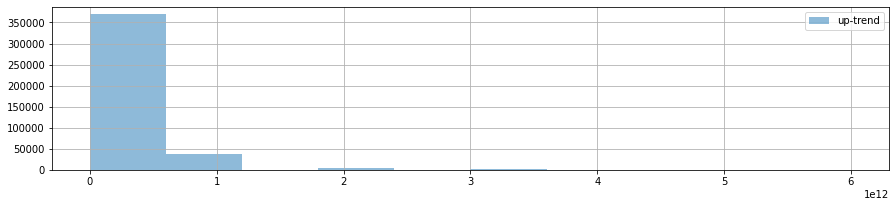

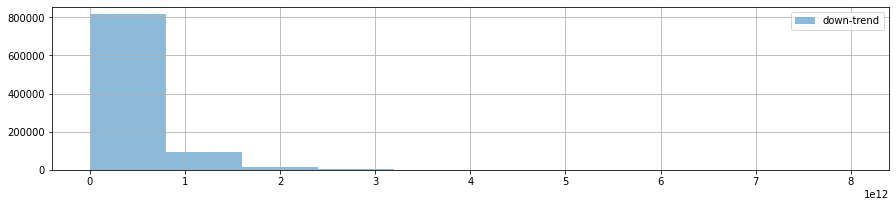

In [38]:
eps = 1e-12
pos_neg_lm_ratio = (pos_neg_lm[:, 0]+eps) / (pos_neg_lm[:, 1]+eps)
labels = text_crypto_agg["label"].values
pos_idx = np.where(labels == 1.0)
neg_idx = np.where(labels == -1.0)

plt.figure(figsize=(15, 3))
plt.hist(pos_neg_lm_ratio[pos_idx], alpha=0.5, label="up-trend")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15, 3))
plt.hist(pos_neg_lm_ratio[neg_idx], alpha=0.5, label="down-trend")
plt.legend()
plt.grid()
plt.show()

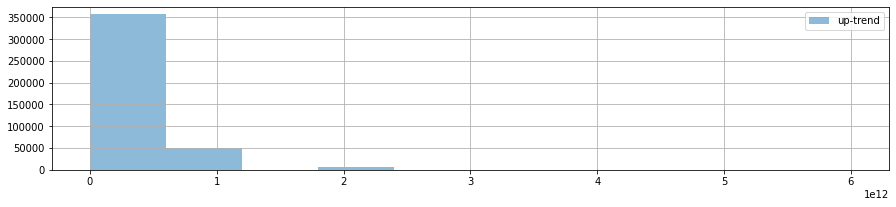

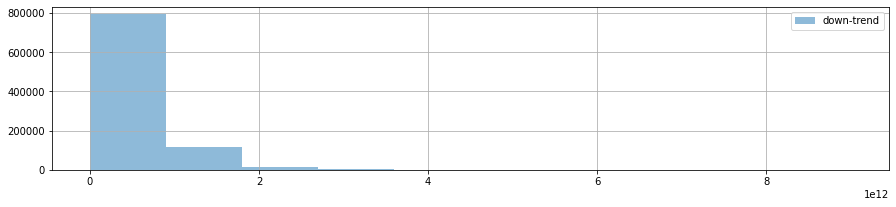

In [39]:
eps = 1e-12
pos_neg_h_ratio = (pos_neg_h[:, 0]+eps) / (pos_neg_h[:, 1]+eps)
labels = text_crypto_agg["label"].values
pos_idx = np.where(labels == 1.0)
neg_idx = np.where(labels == -1.0)

plt.figure(figsize=(15, 3))
plt.hist(pos_neg_h_ratio[pos_idx], alpha=0.5, label="up-trend")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15, 3))
plt.hist(pos_neg_h_ratio[neg_idx], alpha=0.5, label="down-trend")
plt.legend()
plt.grid()
plt.show()

In [40]:
def parse_polarity(score):
    if score < 0:
        return -1
    elif score > 0:
        return 1
    else:
        return 0

text_crypto_agg_lm["polarity"] = text_crypto_agg_lm["pos_count"] - text_crypto_agg_lm["neg_count"]
text_crypto_agg_lm["polarity"] = text_crypto_agg_lm["polarity"].swifter.apply(parse_polarity)

Pandas Apply:   0%|          | 0/1338472 [00:00<?, ?it/s]

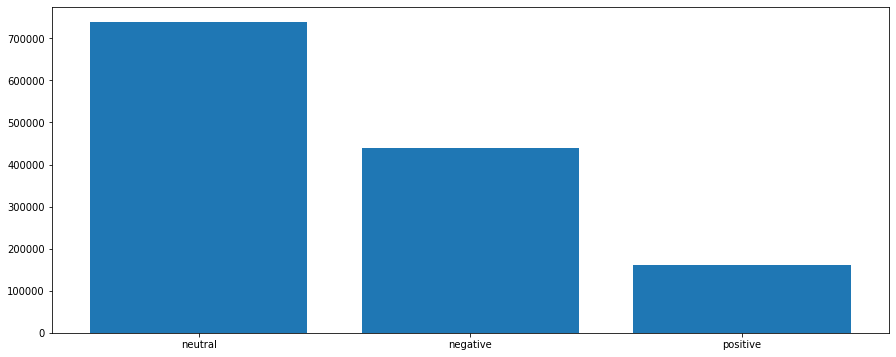

In [41]:
plt.bar(["neutral", "negative", "positive"], text_crypto_agg_lm.polarity.value_counts())
plt.show()

In [42]:
text_crypto_agg_h["polarity"] = text_crypto_agg_h["pos_count"] - text_crypto_agg_h["neg_count"]
text_crypto_agg_h["polarity"] = text_crypto_agg_h["polarity"].swifter.apply(parse_polarity)

Pandas Apply:   0%|          | 0/1338472 [00:00<?, ?it/s]

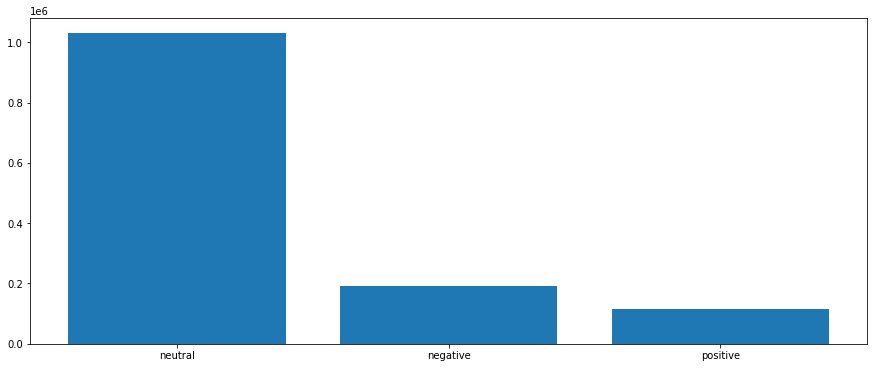

In [43]:
plt.bar(["neutral", "negative", "positive"], text_crypto_agg_h.polarity.value_counts())
plt.show()

### Train Naive Bayes Classifier and Logistic Regression Classifier

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

In [45]:
text_crypto_agg_train = text_crypto_agg[:int(len(text_crypto_agg)*0.8)]
text_crypto_agg_valid = text_crypto_agg[int(len(text_crypto_agg)*0.8):]

text_crypto_agg_lm_train = text_crypto_agg_lm[:int(len(text_crypto_agg_lm)*0.8)]
text_crypto_agg_lm_valid = text_crypto_agg_lm[int(len(text_crypto_agg_lm)*0.8):]

text_crypto_agg_h_train = text_crypto_agg_h[:int(len(text_crypto_agg_h)*0.8)]
text_crypto_agg_h_valid = text_crypto_agg_h[int(len(text_crypto_agg_h)*0.8):]

#### Count-based

In [46]:
text_count_lm_nb_clf = Pipeline([
    ('count', CountVectorizer()),
    ('clf', MultinomialNB()),
])
text_count_lm_nb_clf.fit(text_crypto_agg_train["title"], text_crypto_agg_lm_train["polarity"])
print(metrics.classification_report(text_count_lm_nb_clf.predict(text_crypto_agg_valid["title"]), 
                                    text_crypto_agg_lm_valid["polarity"]))
print(metrics.confusion_matrix(text_count_lm_nb_clf.predict(text_crypto_agg_valid["title"]), 
                               text_crypto_agg_lm_valid["polarity"]))
print(metrics.f1_score(text_count_lm_nb_clf.predict(text_crypto_agg_valid["title"]), 
                       text_crypto_agg_lm_valid["polarity"], 
                       average='weighted'))

              precision    recall  f1-score   support

          -1       0.75      0.80      0.77     71150
           0       0.73      0.83      0.78    130900
           1       0.76      0.52      0.61     65645

    accuracy                           0.74    267695
   macro avg       0.75      0.71      0.72    267695
weighted avg       0.74      0.74      0.74    267695

[[ 56601  13429   1120]
 [ 13137 108313   9450]
 [  5236  26581  33828]]
0.7360381196451216


In [47]:
text_count_h_nb_clf = Pipeline([
    ('count', CountVectorizer()),
    ('clf', MultinomialNB()),
])
text_count_h_nb_clf.fit(text_crypto_agg_train["title"], text_crypto_agg_h_train["polarity"])
print(metrics.classification_report(text_count_h_nb_clf.predict(text_crypto_agg_valid["title"]), 
                                    text_crypto_agg_h_valid["polarity"]))
print(metrics.confusion_matrix(text_count_h_nb_clf.predict(text_crypto_agg_valid["title"]), 
                               text_crypto_agg_h_valid["polarity"]))
print(metrics.f1_score(text_count_h_nb_clf.predict(text_crypto_agg_valid["title"]), 
                       text_crypto_agg_h_valid["polarity"], 
                       average='weighted'))

              precision    recall  f1-score   support

          -1       0.57      0.60      0.59     19681
           0       0.90      0.92      0.91    196581
           1       0.82      0.74      0.78     51433

    accuracy                           0.86    267695
   macro avg       0.76      0.75      0.76    267695
weighted avg       0.86      0.86      0.86    267695

[[ 11872   7535    274]
 [  8478 179920   8183]
 [   513  12698  38222]]
0.8588132677957879


In [48]:
text_count_lm_lr_clf = Pipeline([
    ('count', CountVectorizer()),
    ('clf', SGDClassifier(loss="log")),
])
text_count_lm_lr_clf.fit(text_crypto_agg_train["title"], text_crypto_agg_lm_train["polarity"])
print(metrics.classification_report(text_count_lm_lr_clf.predict(text_crypto_agg_valid["title"]), 
                                    text_crypto_agg_lm_valid["polarity"]))
print(metrics.confusion_matrix(text_count_lm_lr_clf.predict(text_crypto_agg_valid["title"]), 
                               text_crypto_agg_lm_valid["polarity"]))
print(metrics.f1_score(text_count_lm_lr_clf.predict(text_crypto_agg_valid["title"]), 
                       text_crypto_agg_lm_valid["polarity"], 
                       average='weighted'))

              precision    recall  f1-score   support

          -1       0.78      0.93      0.85     62743
           0       0.93      0.83      0.88    166857
           1       0.72      0.84      0.77     38095

    accuracy                           0.85    267695
   macro avg       0.81      0.87      0.83    267695
weighted avg       0.87      0.85      0.86    267695

[[ 58246   4374    123]
 [ 15836 138604  12417]
 [   892   5345  31858]]
0.8563903080465868


In [49]:
text_count_h_lr_clf = Pipeline([
    ('count', CountVectorizer()),
    ('clf', SGDClassifier(loss="log")),
])
text_count_h_lr_clf.fit(text_crypto_agg_train["title"], text_crypto_agg_h_train["polarity"])
print(metrics.classification_report(text_count_h_lr_clf.predict(text_crypto_agg_valid["title"]), 
                                    text_crypto_agg_h_valid["polarity"]))
print(metrics.confusion_matrix(text_count_h_lr_clf.predict(text_crypto_agg_valid["title"]), 
                               text_crypto_agg_h_valid["polarity"]))
print(metrics.f1_score(text_count_h_lr_clf.predict(text_crypto_agg_valid["title"]), 
                       text_crypto_agg_h_valid["polarity"], 
                       average='weighted'))

              precision    recall  f1-score   support

          -1       0.83      0.88      0.85     19602
           0       0.98      0.96      0.97    204280
           1       0.88      0.94      0.91     43813

    accuracy                           0.95    267695
   macro avg       0.89      0.92      0.91    267695
weighted avg       0.95      0.95      0.95    267695

[[ 17252   2319     31]
 [  3289 195382   5609]
 [   322   2452  41039]]
0.9482036634279845


#### TFIDF-based

In [50]:
text_tfidf_lm_nb_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])
text_tfidf_lm_nb_clf.fit(text_crypto_agg_train["title"], text_crypto_agg_lm_train["polarity"])
print(metrics.classification_report(text_tfidf_lm_nb_clf.predict(text_crypto_agg_valid["title"]), 
                                    text_crypto_agg_lm_valid["polarity"]))
print(metrics.confusion_matrix(text_tfidf_lm_nb_clf.predict(text_crypto_agg_valid["title"]), 
                               text_crypto_agg_lm_valid["polarity"]))
print(metrics.f1_score(text_tfidf_lm_nb_clf.predict(text_crypto_agg_valid["title"]), 
                       text_crypto_agg_lm_valid["polarity"], 
                       average='weighted'))

              precision    recall  f1-score   support

          -1       0.63      0.88      0.73     53480
           0       0.95      0.68      0.79    208282
           1       0.11      0.82      0.19      5933

    accuracy                           0.72    267695
   macro avg       0.56      0.79      0.57    267695
weighted avg       0.87      0.72      0.77    267695

[[ 47083   5914    483]
 [ 27819 141407  39056]
 [    72   1002   4859]]
0.76778864435133


In [51]:
text_tfidf_h_nb_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])
text_tfidf_h_nb_clf.fit(text_crypto_agg_train["title"], text_crypto_agg_h_train["polarity"])
print(metrics.classification_report(text_tfidf_h_nb_clf.predict(text_crypto_agg_valid["title"]), 
                                    text_crypto_agg_h_valid["polarity"]))
print(metrics.confusion_matrix(text_tfidf_h_nb_clf.predict(text_crypto_agg_valid["title"]), 
                               text_crypto_agg_h_valid["polarity"]))
print(metrics.f1_score(text_tfidf_h_nb_clf.predict(text_crypto_agg_valid["title"]), 
                       text_crypto_agg_h_valid["polarity"], 
                       average='weighted'))

              precision    recall  f1-score   support

          -1       0.05      0.62      0.08      1525
           0       0.99      0.76      0.86    260649
           1       0.10      0.88      0.19      5521

    accuracy                           0.76    267695
   macro avg       0.38      0.75      0.38    267695
weighted avg       0.97      0.76      0.85    267695

[[   943    570     12]
 [ 19893 198934  41822]
 [    27    649   4845]]
0.845007285303449


In [52]:
text_tfidf_lm_lr_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SGDClassifier(loss="log")),
])
text_tfidf_lm_lr_clf.fit(text_crypto_agg_train["title"], text_crypto_agg_lm_train["polarity"])
print(metrics.classification_report(text_tfidf_lm_lr_clf.predict(text_crypto_agg_valid["title"]), 
                                    text_crypto_agg_lm_valid["polarity"]))
print(metrics.confusion_matrix(text_tfidf_lm_lr_clf.predict(text_crypto_agg_valid["title"]), 
                               text_crypto_agg_lm_valid["polarity"]))
print(metrics.f1_score(text_tfidf_lm_lr_clf.predict(text_crypto_agg_valid["title"]), 
                       text_crypto_agg_lm_valid["polarity"], 
                       average='weighted'))

              precision    recall  f1-score   support

          -1       0.41      0.91      0.57     34343
           0       0.98      0.64      0.78    224888
           1       0.17      0.89      0.29      8464

    accuracy                           0.68    267695
   macro avg       0.52      0.81      0.54    267695
weighted avg       0.88      0.68      0.73    267695

[[ 31088   2954    301]
 [ 43720 144632  36536]
 [   166    737   7561]]
0.7331403490092864


In [53]:
text_tfidf_h_lr_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SGDClassifier(loss="log")),
])
text_tfidf_h_lr_clf.fit(text_crypto_agg_train["title"], text_crypto_agg_h_train["polarity"])
print(metrics.classification_report(text_tfidf_h_lr_clf.predict(text_crypto_agg_valid["title"]), 
                                    text_crypto_agg_h_valid["polarity"]))
print(metrics.confusion_matrix(text_tfidf_h_lr_clf.predict(text_crypto_agg_valid["title"]), 
                               text_crypto_agg_h_valid["polarity"]))
print(metrics.f1_score(text_tfidf_h_lr_clf.predict(text_crypto_agg_valid["title"]), 
                       text_crypto_agg_h_valid["polarity"], 
                       average='weighted'))

              precision    recall  f1-score   support

          -1       0.09      0.86      0.17      2216
           0       0.99      0.78      0.87    254147
           1       0.22      0.89      0.35     11332

    accuracy                           0.79    267695
   macro avg       0.43      0.85      0.46    267695
weighted avg       0.95      0.79      0.85    267695

[[  1905    304      7]
 [ 18871 198730  36546]
 [    87   1119  10126]]
0.8467515468756865


#### Performance

| Vectoriser | Classifier | SentimentDict | F1 (Negative/Neutral/Positive) |
| :-: | :-: | :-: | :-: |
| Count | NaiveBayes         | Loughran and McDonald (2011) | 0.7438 (0.78/0.78/0.61) |
| Count | LogisticRegression | Henry's (2008)               | 0.8701 (0.56/0.92/0.78) |
| Count | NaiveBayes         | Loughran and McDonald (2011) | 0.8625 (0.86/0.89/0.75) |
| Count | LogisticRegression | Henry's (2008)               | 0.9536 (0.85/0.97/0.91) |
| TFIDF | NaiveBayes         | Loughran and McDonald (2011) | 0.7841 (0.76/0.80/0.15) |
| TFIDF | LogisticRegression | Henry's (2008)               | 0.8625 (0.07/0.88/0.19) |
| TFIDF | NaiveBayes         | Loughran and McDonald (2011) | 0.7508 (0.62/0.79/0.19) |
| TFIDF | LogisticRegression | Henry's (2008)               | 0.8647 (0.11/0.89/0.33) |

### Visualise on Sentiment

In [54]:
from backtest.fin_backtest import signal2trend, trend2signal, MarketPortfolio

In [55]:
proba = text_count_h_lr_clf.predict_proba(text_crypto_agg_valid["title"])

In [56]:
trend_positive_df = pd.DataFrame(proba[:, 2], index=text_crypto_agg_valid.index, columns=["trend"])
trend_positive_df = trend_positive_df.groupby(trend_positive_df.index).agg({"trend":"mean"})

trend_negative_df = pd.DataFrame(proba[:, 0], index=text_crypto_agg_valid.index, columns=["trend"])
trend_negative_df = trend_negative_df.groupby(trend_negative_df.index).agg({"trend":"mean"})

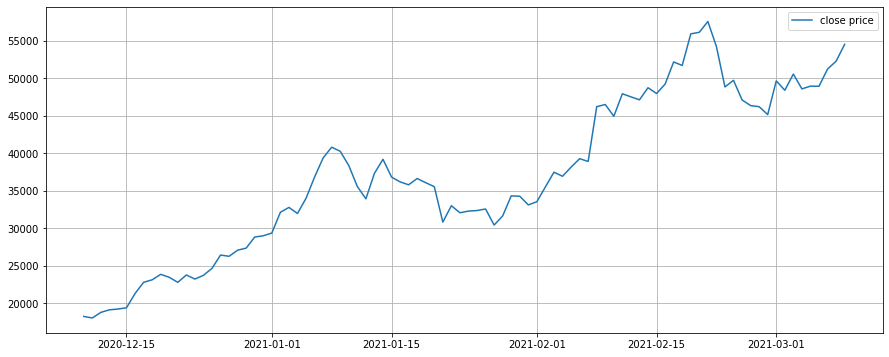

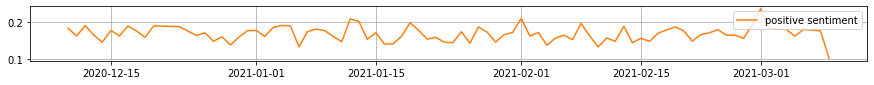

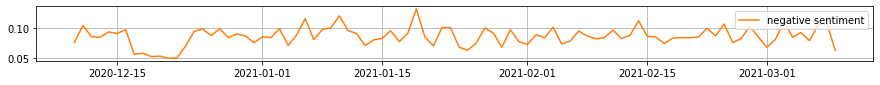

In [57]:
LOOKBACK = 90

plt.plot(crypto_df.iloc[-LOOKBACK:, ].close, label="close price")
plt.legend(loc="upper right")
plt.grid()
plt.show()

plt.figure(figsize=(15, 1))
plt.plot(crypto_df.iloc[-LOOKBACK:, ].close.index, trend_positive_df.trend[-LOOKBACK:], 
         color="tab:orange", label="positive sentiment")
plt.legend(loc="upper right")
plt.grid()
plt.show()

plt.figure(figsize=(15, 1))
plt.plot(crypto_df.iloc[-LOOKBACK:, ].close.index, trend_negative_df.trend[-LOOKBACK:], 
         color="tab:orange", label="negative sentiment")
plt.legend(loc="upper right")
plt.grid()
plt.show()

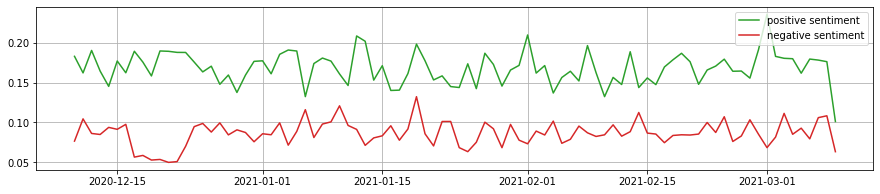

In [58]:
LOOKBACK=90

plt.figure(figsize=(15, 3))
plt.plot(crypto_df.iloc[-LOOKBACK:, ].close.index, trend_positive_df.trend[-LOOKBACK:], 
         color="tab:green", label="positive sentiment")
plt.plot(crypto_df.iloc[-LOOKBACK:, ].close.index, trend_negative_df.trend[-LOOKBACK:], 
         color="tab:red", label="negative sentiment")
plt.legend(loc="upper right")
plt.grid()
plt.show()

In [59]:
median = trend_positive_df.trend.rolling(10).median()
p1 = trend_positive_df.trend > median
p2 = trend_positive_df.trend.shift() > median
sentiment = (p1 & p2).astype(int).rolling(10).mean()

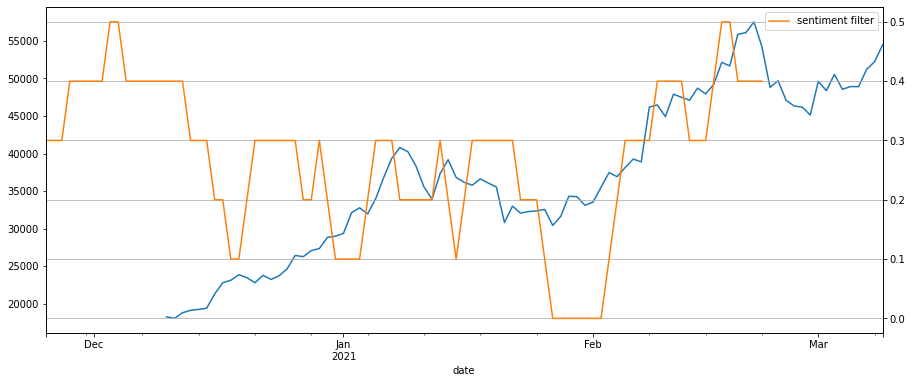

In [60]:
crypto_df.iloc[-LOOKBACK:, ].close.plot(label="close price")
sentiment.iloc[-LOOKBACK:, ].plot(secondary_y=True, label="sentiment filter")
plt.legend(loc="upper right")
plt.grid()
plt.show()

$$S-Score=\frac{positive - negative}{positive + negative}$$

Inspired from Colton Smith's [blog](http://epchan.blogspot.com/2017/09/stocktwits-sentiment-analysis_7.html) and [The Financial Hacker](https://financial-hacker.com/the-market-meanness-index/).

In [65]:
sentiment_df = (trend_positive_df.trend-trend_negative_df.trend) / (trend_positive_df.trend+trend_negative_df.trend)
sentiment_df = pd.DataFrame(sentiment_df, columns=["trend"])
median = sentiment_df.trend.rolling(10).median()
p1 = sentiment_df.trend > median
p2 = sentiment_df.trend.shift() > median
sentiment = (p1 & p2).astype(int).rolling(10).mean()

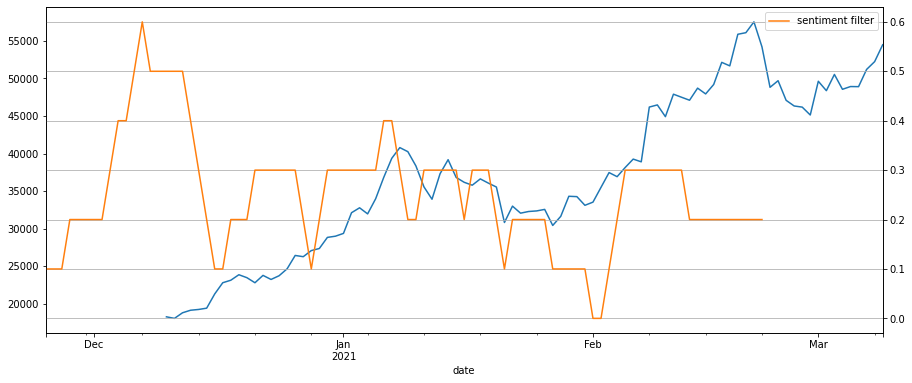

In [66]:
crypto_df.iloc[-LOOKBACK:, ].close.plot(label="close price")
sentiment.iloc[-LOOKBACK:, ].plot(secondary_y=True, label="sentiment filter")
plt.legend(loc="upper right")
plt.grid()
plt.show()